# Analysing the dataset Store Item Demand Forecasting

In [1]:
import pandas as pd
import os

In [2]:
path = os.getcwd()

In [3]:
data_path = path.replace('Model','Data')

In [4]:
file = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# EDA and Data Cleaning Process

## Reading the dataset

In [5]:
df = pd.read_csv(os.path.join(data_path,file[-1]))

In [6]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
df['date'] = pd.to_datetime(df.date)

In [8]:
df['month'] = df.date.dt.month

In [9]:
df.head()

,date,store,item,sales,month
0,2013-01-01,1,1,13,1
1,2013-01-02,1,1,11,1
2,2013-01-03,1,1,14,1
3,2013-01-04,1,1,13,1
4,2013-01-05,1,1,10,1


In [10]:
print(f'This dataset has {df.shape[0]} lines and {df.shape[1]} columns.')

This dataset has 913000 lines and 5 columns.


## Checking for nulls

In [11]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
month    0
dtype: int64

## Summarizing data by date

In [12]:
df2 = df.groupby(by='month').sum()[['store','item','sales']]

## Checking datatypes of dataset

In [13]:
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
month             int64
dtype: object

# Analysing the feature's behaviors beyond the Year

In [14]:
def generategraphs(dataframe,feature):
    import matplotlib.pyplot as plt
    import seaborn as sns
    ax,fig = plt.subplots()
    ax.set_size_inches(10,6)
    fig.set_title(f'Distribution of {feature} on the Year')
    sns.barplot(x=dataframe.index,y=feature,data=dataframe,palette="Blues")

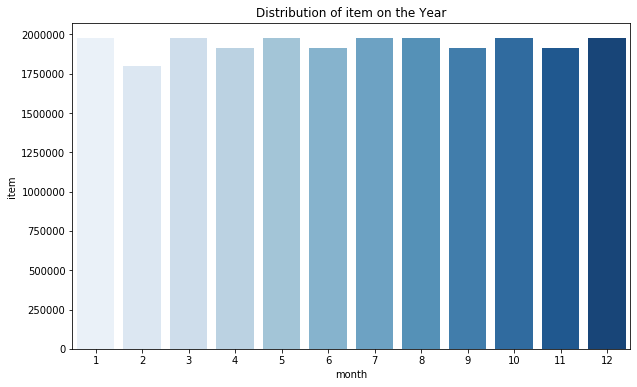

In [15]:
generategraphs(df2,'item')

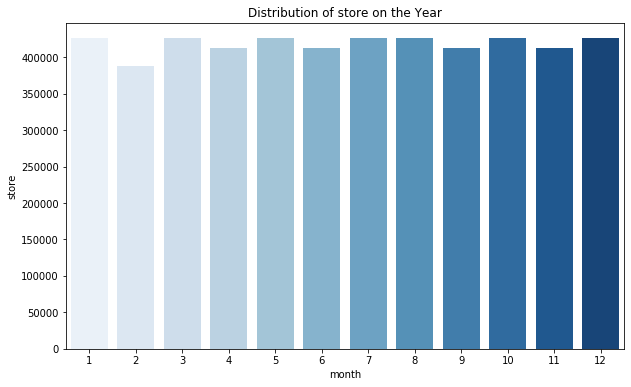

In [16]:
generategraphs(df2,'store')

# As we can see above, the feature "price" has a behavior similar to a normal distribution, but it's necessary to check with another tests

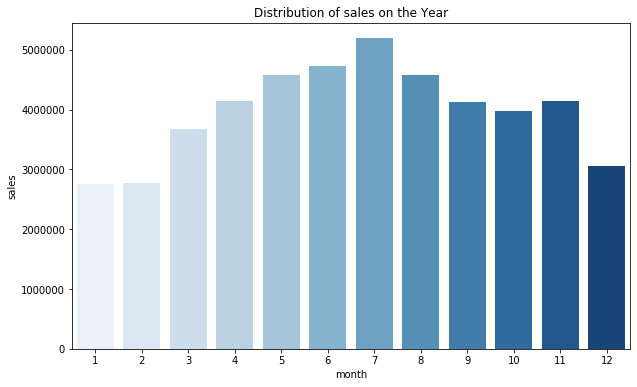

In [17]:
generategraphs(df2,'sales')

# Checking correlation of target variable

In [18]:
pd.DataFrame((df.corr().loc['sales']*100).round(2))

,sales
store,-0.82
item,-5.60
sales,100.00
month,8.74


# Preparing a dataframe summarizing by 6 months

In [19]:
def get_six_months(firstmonth,dataframe):
    ''' This function returns the next six months based on the first month passed by parameter.'''
    return dataframe[(dataframe['month'] >= firstmonth) & (dataframe['month'] <= firstmonth+6)]

In [20]:
first_six_months = get_six_months(0,df)

In [21]:
first_six_months

,date,store,item,sales,month
0,2013-01-01,1,1,13,1
1,2013-01-02,1,1,11,1
2,2013-01-03,1,1,14,1
3,2013-01-04,1,1,13,1
4,2013-01-05,1,1,10,1
...,...,...,...,...,...
912811,2017-06-26,10,50,82,6
912812,2017-06-27,10,50,83,6
912813,2017-06-28,10,50,91,6
912814,2017-06-29,10,50,122,6


In [67]:
last_six_months = get_six_months(7,df)

In [68]:
last_six_months

,date,store,item,sales,month
181,2013-07-01,1,1,23,7
182,2013-07-02,1,1,17,7
183,2013-07-03,1,1,12,7
184,2013-07-04,1,1,24,7
185,2013-07-05,1,1,17,7
...,...,...,...,...,...
912995,2017-12-27,10,50,63,12
912996,2017-12-28,10,50,59,12
912997,2017-12-29,10,50,74,12
912998,2017-12-30,10,50,62,12


## Splitting the dataset between train and test and generating linear regression model

In [79]:
def predict_by_month(dataframe):
    ''' This function returns predictions by month based on a dataframe passed by parameter.'''
    from numpy.random import seed
    seed(42)    
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    months = dataframe.month.unique()
    predictions = []
    y_true = []
    
    for i in months:
        #Separing date by month to generate predictions
        df_aux = dataframe[dataframe['month'] == i]
        X = df_aux.drop(columns=['date','sales'])
        y = df_aux.sales
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        model = LinearRegression(normalize=True)
        model.fit(X_train,y_train)
        predictions.append(model.predict(X_test))
        y_true.append(y_test)
    return predictions,y_true

In [80]:
predictions_fs,y_fs = predict_by_month(first_six_months)

In [81]:
from sklearn.preprocessing import normalize

In [98]:
def normalizedata(x_dataset,y_dataset):
    
    min_value = len(x_dataset[0])
    for i in x_dataset:
        if len(i) < min_value:
            min_value = len(i)
    x2 = []        
    for i in x_dataset:
        x2.append(i[0:min_value])
        
    y2 = []
    for i in y_dataset:
        y2.append(i[0:min_value])
    
    return x2,y2

In [99]:
predictions_fs_v2,y_fs_v2 = normalizedata(predictions_fs,y_fs)

In [102]:
predictions_ls,y_ls = predict_by_month(last_six_months)

In [103]:
predictions_ls_v2,y_ls_v2 = normalizedata(predictions_ls,y_ls)

In [106]:
mae_fs = mean_absolute_error(y_fs_v2,predictions_fs_v2)
mae_ls = mean_absolute_error(y_ls_v2,predictions_ls_v2)

In [112]:
print(f'Mean absolute error on First Semesters prediction: {mae_fs.round(2)}. \nMean absolute error on Last Semester`s prediction: {mae_ls.round(2)}.')

Mean absolute error on First Semesters prediction: 20.88. 
Mean absolute error on Last Semester`s prediction: 22.68.
